# Clustering

In [ ]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [ ]:
import numpy as np

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

# Create data

We will use the same data as in [02_meanshift] notebook. Later we will try other data samples.

In [ ]:
torch.manual_seed(42);

In [ ]:
n_clusters = 6
n_samples = 250

In [ ]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [ ]:
def sample(m):
    dist = MultivariateNormal(m, torch.diag(tensor([5., 5.])))
    return dist.sample((n_samples,))

In [ ]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data

tensor([[26.204, 26.349],
        [25.691, 30.213],
        [30.431, 28.693],
        ...,
        [30.772,  9.323],
        [29.354,  3.960],
        [31.168,  5.309]])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [ ]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        sample = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(sample[:,0], sample[:,1], s=1, alpha=0.7)
        ax.plot(*centroid, marker='x', color='k', markersize=10, mew=5)
        ax.plot(*centroid, marker='x', color='m', markersize=5, mew=2)

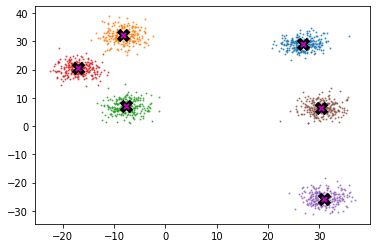

In [ ]:
plot_data(centroids, data, n_samples)

# K-means clustering 

K-means algorithm is considered one of the most popular clustering algorithms, mainly due to its simplicity. The main idea it to separate the data into K separate clusters, each cluster should as homogeneous as possible. This is achieved by minimizing the sum of squares between each point and the centroid of its cluster. 

1. Specify number of clusters K.
2. Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.
3. Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing:
    * Compute the sum of the squared distance between data points and all centroids.
    * Assign each data point to the closest cluster (centroid).
    * Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.

In [ ]:
torch.manual_seed(42);
X = data.clone()

In [ ]:
# number of clusters
K = 6

# shuffle the dataset
random_indices = torch.randperm(len(X))
shuffled = X[random_indices] 

In [ ]:
centroids = shuffled[:K]
centroids

tensor([[ 21.147,  30.141],
        [ -8.459,  35.216],
        [ 33.263, -27.666],
        [-14.092,  20.555],
        [ 31.336, -28.549],
        [ 28.315, -27.046]])

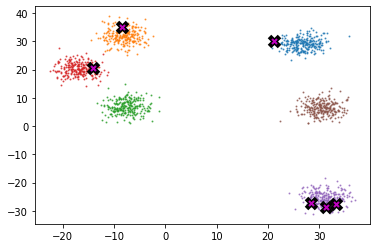

In [ ]:
plot_data(centroids, data, n_samples)

In [ ]:
centroids.shape, shuffled.shape

(torch.Size([6, 2]), torch.Size([1500, 2]))

In [ ]:
dist = ((centroids[:, None] - shuffled[None])**2).sum(2)

In [ ]:
dist.shape

torch.Size([6, 1500])

`dist` stores the distance for each centroid to each of the points. We can now check to what centroid the data point is closer to. This will allow us to reshufle the data.

In [ ]:
dist

tensor([[    0.000,   902.303,  3488.547,  ...,  1407.141,  1535.139,  1544.097],
        [  902.303,     0.000,  5694.972,  ...,   283.403,   206.787,   301.390],
        [ 3488.547,  5694.972,     0.000,  ...,  4555.254,  5261.373,  4779.967],
        [ 1333.688,   246.670,  4567.792,  ...,     1.423,    24.501,     7.732],
        [ 3548.317,  5649.557,     4.494,  ...,  4457.672,  5161.225,  4675.489],
        [ 3321.757,  5228.859,    24.874,  ...,  4045.043,  4718.980,  4250.030]])

In [ ]:
clusters_idx = torch.argmin(dist, dim=0)
clusters_idx

tensor([0, 1, 2,  ..., 3, 3, 3])

We now need to update centroids based on the average of observations that falls into their cluster! Trivial implementation involves looping through the centroids and indexing into the `data` that is closest to this cluster (via `clusters_idx`)

In [ ]:
shuffled[clusters_idx==0].mean(dim=0)

tensor([28.582, 18.077])

In [ ]:
for i in range(K):
    centroids[i] = (shuffled[clusters_idx==i]).mean(dim=0)
centroids

tensor([[ 28.582,  18.077],
        [ -8.142,  32.233],
        [ 33.339, -24.982],
        [-12.269,  13.860],
        [ 31.092, -27.936],
        [ 29.056, -23.473]])

How to do it more efficiently? Maybe one-hot encode the clusters_idx?

In [ ]:
import torch.nn.functional as F

In [ ]:
coh_idx = F.one_hot(clusters_idx, num_classes = 6).to(torch.float32);coh_idx

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.]])

In [ ]:
centroids.shape, shuffled.shape, coh_idx.shape

(torch.Size([6, 2]), torch.Size([1500, 2]), torch.Size([1500, 6]))

In [ ]:
shuffled[:, None].shape

torch.Size([1500, 1, 2])

In [ ]:
coh_idx.T

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
shuffled

tensor([[ 21.147,  30.141],
        [ -8.459,  35.216],
        [ 33.263, -27.666],
        ...,
        [-14.867,  19.649],
        [-17.562,  24.084],
        [-16.816,  19.999]])

The idea is to treat clusters_idx as a lookup table by one-hot encoding it. Then we transpose and matrix-multiply it by X which allows to pluck all of the Xs relevant to the cluster (where row of coh_idx.T is 1) and sum them up. Then we divide by the sum of the items in each cluster.

In [ ]:
(coh_idx.T @ shuffled) / (coh_idx.T).sum(1, keepdim=True)

tensor([[ 28.582,  18.077],
        [ -8.142,  32.233],
        [ 33.339, -24.982],
        [-12.269,  13.860],
        [ 31.092, -27.936],
        [ 29.056, -23.473]])

We get the same result!!!! That's amazing!

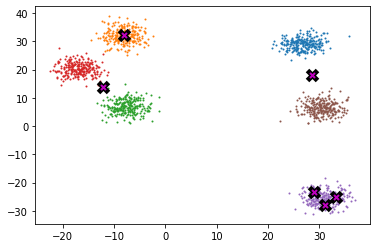

In [ ]:
plot_data(centroids, data, n_samples)

### Now let's group it all in a function

In [ ]:
def one_update(centroids, X):
    dist = ((centroids[:, None] - X[None])**2).sum(2)
    clusters_idx = torch.argmin(dist, dim=0)
    
    for j in range(centroids.shape[0]):
        centroids[j] = (shuffled[clusters_idx==j]).mean(dim=0)

In [ ]:
def kmeans(data, K=6, n=5, seed=None): 
    X = data.clone()
    
    if seed: torch.manual_seed(seed) # for reproducibility
    random_indices = torch.randperm(len(X)) # shuffle the dataset
    X = X[random_indices]
    
    centroids = X[:K] # initialize centroids
    # print(centroids)
    for _ in range(n):
        one_update(centroids, X)
    return centroids




In [ ]:
centroids = kmeans(data, n=100, seed=42)
centroids

tensor([[ 28.618,  17.822],
        [ -8.626,  31.652],
        [ 33.621, -24.804],
        [-12.189,  13.323],
        [ 30.231, -27.496],
        [ 29.248, -23.620]])

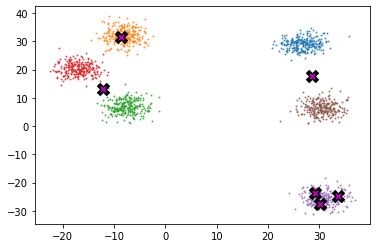

In [ ]:
plot_data(centroids, data, n_samples)

In [ ]:
def predict(X):
    distance = self.compute_distance(X, self.centroids)
    return self.find_closest_cluster(distance)

In [ ]:
x = np.linspace(data[:,0].min()-0.5, data[:,0].max()+0.5, 100)
y =  np.linspace(data[:,1].min()-0.5, data[:,1].max()+0.5, 100)
xx, yy = np.meshgrid(x,y)
xy = np.array([xx.ravel(), yy.ravel()]).T

In [ ]:
dist = ((centroids[:, None] - xy[None])**2).sum(2)
zz = torch.argmin(dist, dim=0)
Z = zz.reshape(xx.shape)

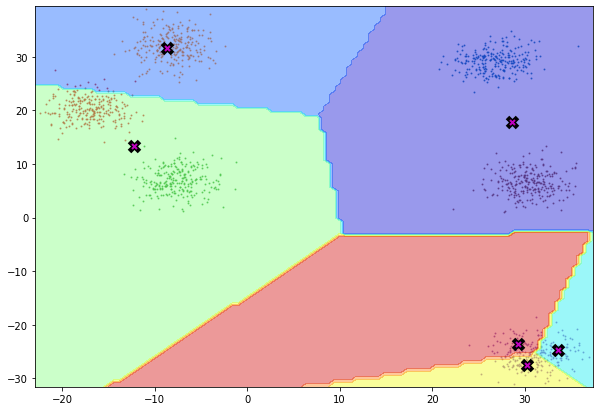

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
plot_data(centroids, data, n_samples, ax)
ax.contourf(xx, yy, Z, alpha=0.4, cmap='jet');

###  Now let's try with sklearn

Check how much better it is and implement some tricks. Namely: scaling, running several inits

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

In [ ]:
X = data.clone()

In [ ]:
# Standardize the data
# X_std = StandardScaler().fit_transform(df)

# Run local implementation of kmeans
km = KMeans(n_clusters=6, init='random', n_init=1, max_iter=1, random_state=42)
km.fit(X)
centroids = km.cluster_centers_

In [ ]:
centroids

array([[ 30.93681081, -25.43389354],
       [ 28.60331163,  17.84659426],
       [ -9.30821544,  30.76070928],
       [ -6.70268567,  32.75873214],
       [-12.32155014,  32.16915598],
       [-12.29342662,  13.58124001]])

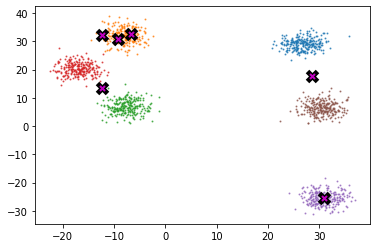

In [ ]:
plot_data(centroids, data, n_samples)

In [ ]:
??KMeans

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='lloyd',
)
Source:        
class KMeans(_BaseKMeans):
    """K-Means clustering.

    Read more in the :ref:`User Guide <k_means>`.

    Parameters
    ----------

    n_clusters : int, default=8
        The number of clusters to form as well as the number of
        centroids to generate.

    init : {'k-means++', 'random'}, callable or array-like of shape \
            (n_clusters, n_features), default='k-means++'
        Method for initialization:

        'k-means++' : selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence. See section
        Notes in k_init for more details.

        'random': choose `n_clusters` observations (rows) at random from data
        for the initial centroids.

        If an array is passed, it should be of shape (n_cluste

In [ ]:
??km.fit

Signature: km.fit(X, y=None, sample_weight=None)
Source:   
    def fit(self, X, y=None, sample_weight=None):
        """Compute k-means clustering.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster. It must be noted that the data
            will be converted to C ordering, which will cause a memory
            copy if the given data is not C-contiguous.
            If a sparse matrix is passed, a copy will be made if it's not in
            CSR format.

        y : Ignored
            Not used, present here for API consistency by convention.

        sample_weight : array-like of shape (n_samples,), default=None
            The weights for each observation in X. If None, all observations
            are assigned equal weight.

            .. versionadded:: 0.20

        Returns
        -------
        self : object
            Fitted estimator.
        """
        X = self._validat

## Mean shift 

Most widely known clustering algorithm is __k-means__. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:

* It doesn't require selecting the number of clusters in advance, but instead just requires a bandwidth to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:

* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the Gaussian kernel of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer to their mass gravity center until they are next to each other.

In [ ]:
midp = data.mean(0)
midp

tensor([ 9.222, 11.604])

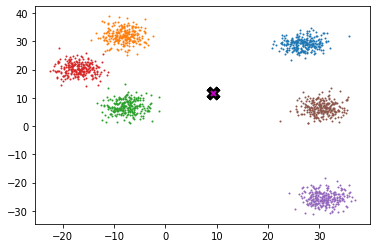

In [ ]:
plot_data([midp]*6, data, n_samples)

In [ ]:
# gaussian kernel for data (d) and bandwidth (bw)
def gaussian(d, bw): return torch.exp(-0.5 * (d/bw)**2) / (bw*math.sqrt(2*math.pi))

In [ ]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

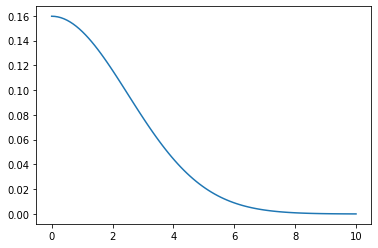

In [ ]:
plot_func(partial(gaussian, bw=2.5))

Guassian kernel is used to lookup the weights depending on the distance between points - the larger the distance, the smaller the weight.

In our implementation, we choose the bandwidth to be 2.5.

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [ ]:
X = data.clone() # copy of data
x = X[0] # single point

In [ ]:
x

tensor([26.204, 26.349])

In [ ]:
X.shape, x.shape

(torch.Size([1500, 2]), torch.Size([2]))

We need to calculate the distance between each point and the remaining data. The shape of the data is (1500, 2) and the shape of a single point is (2). Accoridng to the rules of broadcasting those shapes are compatible:

    X ->       (1500, 2)
    x ->          (1, 2)
    x ->       (1500, 2)

In [ ]:
x - X

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        ...,
        [-4.568, 17.025],
        [-3.151, 22.389],
        [-4.964, 21.040]])

I prefer to be explicit and directly add extra dimension by indexing into x with np.newaxis, which is equal to None

In [ ]:
x[None] - X

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        ...,
        [-4.568, 17.025],
        [-3.151, 22.389],
        [-4.964, 21.040]])

We calcalate the distance for each point by subtracting from broadcasted point matrix of all other points, summing the squared the difference and taking the square root. 

For a single point ($x_{1},y_{1}$) it is as follows: $\sqrt{(x_{1}-x_{2})^2 + (y_{1}-y_{2})^2}$

In [ ]:
distance = (((x[None] - X)**2).sum(1)).sqrt()
distance[:8], distance.shape

(tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002]),
 torch.Size([1500]))

We can rewrite the square and multiplication operating in distance with the following Einstein summation

In [ ]:
diff = (x[None] - X)
diff.shape

ein_distance = torch.einsum('ik,ik->i', diff, diff).sqrt()
ein_distance[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

Now we have the distances and we need to weight them according to the Gaussian distribution (close distances get higher weights, greated distacnes get less)

In [ ]:
weight = gaussian(distance, bw=2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

Note, that almost all of the weights are basically zero. This means that they can actually be ignored in the weighted sum calcualtion!

In [ ]:
max(weight)

tensor(0.160)

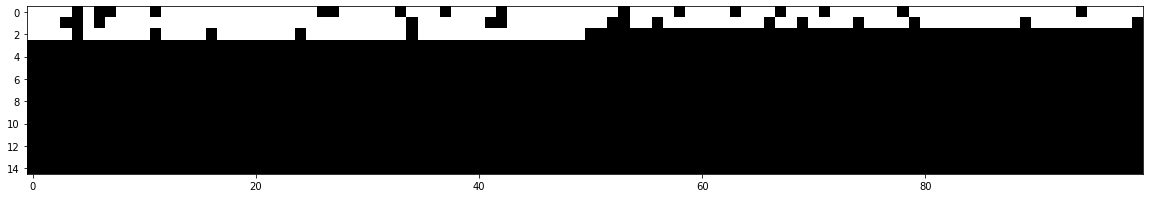

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(weight.reshape(15,100)>0.01, cmap='gray', interpolation='nearest');

We need to get the weighted average of the data points: $\frac{\sum_{i}{x_{i}*w_{i}}}{\sum_{i}{w_{i}}}$

In [ ]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [ ]:
X * weight[:,None]

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [ ]:
def one_update(X):
    for i, x in enumerate(X):
        dist = (((x[None] - X)**2).sum(1)).sqrt()
        weight = gaussian(dist, bw=2.5)
        # we move each point to the direction of the weighted average distance
        X[i] = (X * weight[:, None]).sum(0)/weight.sum()

In [ ]:
def meanshift(data):
    X = data.clone()
    for i in range(5):
        one_update(X)
    return X

In [ ]:
%time X = mean_shift(data)

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.13 s


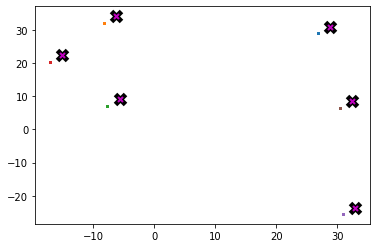

In [ ]:
plot_data(centroids+2, X, n_samples)

###  Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [ ]:
# create animation
X = data.clone()
fig, ax = plt.subplots()
# frames - number of times func (`do_one`) is called
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

### GPU batched algorithm

To accelerate the algorithm, we can run it on a GPU. The main issue is the loop through each data point (1500 in total). This loope cannot be optimized by GPU. Besides, calling GPU calculation inside Python loop can eve increase the total time due to the GPU overheards.

So our goal is to get rid of the loop by using batched of data.

In [ ]:
bs=5
X = data.clone()
x = X[:bs]
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

We need to calculate the difference between each point in a batch and every other point

In [ ]:
#    (5, 2)
# (1500, 2)

# (5, 1500, 2)
# (1, 1500, 2)

In [ ]:
(x[:,None,:] - X[None]).shape

torch.Size([5, 1500, 2])

Note, that we can leave trailing dimensions and not specify `:`

In [ ]:
(x[:,None] - X[None]).shape

torch.Size([5, 1500, 2])

We sum across the last dimension

In [ ]:
((x[:,None] - X[None])**2).sum(-1).sqrt()

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [ ]:
def dist_b(a, b): return ((a[:, None] - b[None])**2).sum(-1).sqrt()

In [ ]:
dist_b(x, X).shape

torch.Size([5, 1500])

In [ ]:
weights = gaussian(dist_b(x, X), bw=2)

In [ ]:
weights.shape, X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [ ]:
(weights[...,None] * X[None]).shape

torch.Size([5, 1500, 2])

The resulting shape is (5, 1500, 2). Which is the distance for each of our 5 examples (which consists of 2 coordinates) to each of the 1500 data points. So we sum over the second dimension

In [ ]:
(weights[...,None] * X[None]).sum(1)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

Note, that we multiply and sum up, which means, we can calculate this as an Einstein sum

In [ ]:
torch.einsum('ik,kj->ij', weights, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

But this means that we are actually just matrix multiplying!

In [ ]:
weights @ X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [ ]:
num = weights @ X

In [ ]:
div = weights.sum(1, keepdim=True)

In [ ]:
num / div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

Now let's combine it all in a single function

In [ ]:
def meanshift(data, bs=64):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            weights = gaussian(dist_b(X[s],X), bw=2.5)
            div = weights.sum(dim=1, keepdim=True)
            X[s] = weights @ X / div
    return X        

In [ ]:
data = data.cuda()

In [ ]:
X = meanshift(data, bs=64).cpu()

In [ ]:
%timeit -n 5 _ = meanshift(data, bs=256).cpu()

5.48 ms ± 352 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


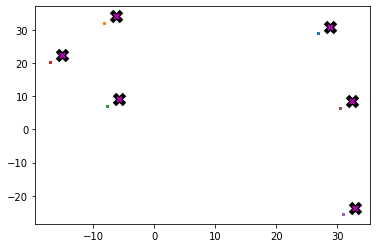

In [ ]:
plot_data(centroids+2, X, n_samples)